# Trabajo Práctico 5 - Grupo 2
## Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

In [29]:
# Import libraries
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import gaussian, convolve2d, fftconvolve
from scipy.interpolate import interp1d
from skimage import color, data, restoration

In [2]:
def display_np(x, scale = 1.0, resampling = Image.Resampling.BICUBIC):
    im = Image.fromarray(x.clip(0, 255).astype(np.uint8))
    display(im.resize((np.array(im.size)*scale).astype(int), resampling))

## Ejercicio 1
### Inverse Filtering

## Ejercicio 2
### Wiener

In [5]:
def blur(img, mode = 'box', kernel_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((kernel_size, kernel_size)) / kernel_size ** 2
    elif mode == 'gaussian':
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

Imagen original:


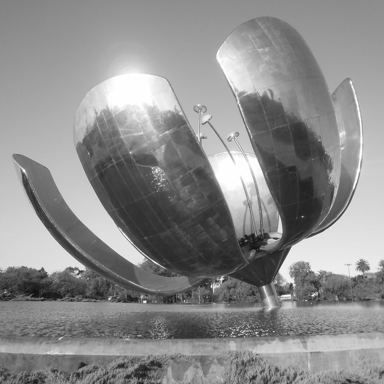

Imagen con blur y noise:


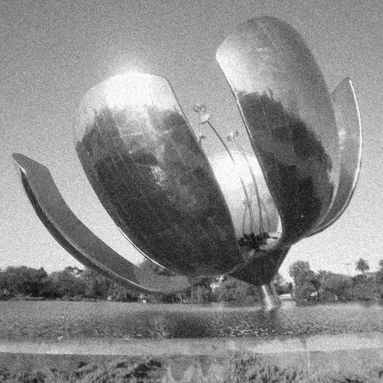

Imagen filtrada:


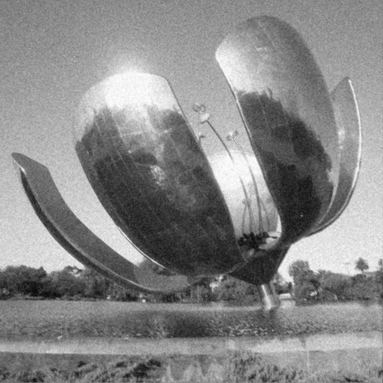

In [7]:
# Abrir la imagen original
img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)

# Aplicar blur
blurred_img = blur(img, mode = 'motion', kernel_size = 3)

# Agregar ruido gausiano
noisy_img = add_gaussian_noise(blurred_img, sigma = 20)

# Aplicar el filtrado de Wiener
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(noisy_img, kernel, K = 30)

# Re-escalado del resultado
filtered_img = interp1d([filtered_img.min(), filtered_img.max()],[img.min(), img.max()])(filtered_img)

print('Imagen original:')
display_np(img, 0.5)
print('Imagen con blur y noise:')
display_np(noisy_img, 0.5)
print('Imagen filtrada:')
display_np(filtered_img, 0.5)

## Ejercicio 3
### Blind deconvolution

Imagen original


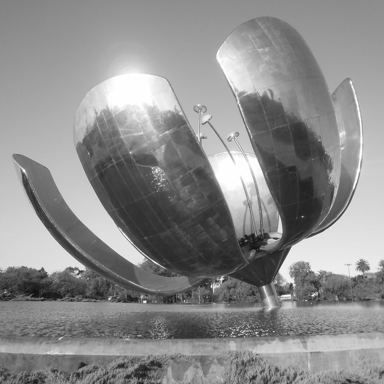

Imagen con blur


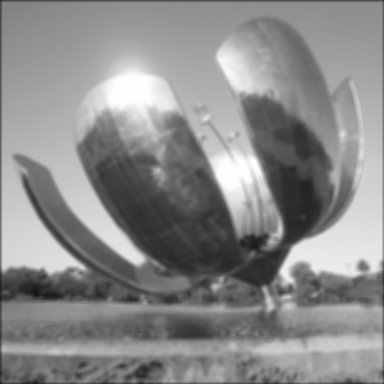

Imagen deconvolucionada


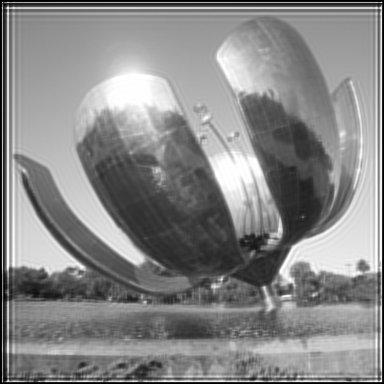

In [47]:
# Source: https://scikit-image.org/docs/dev/auto_examples/filters/plot_deconvolution.html

img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)
img /= img.max()

rng = np.random.default_rng()

psf = np.ones((10, 10)) / 10**2
img_blur = convolve2d(img, psf, 'same')

# Restore Image using Richardson-Lucy algorithm
img_deconvolved = restoration.richardson_lucy(img_blur, psf, num_iter=30)

print('Imagen original:')
display_np(img*255, 0.5)
print('Imagen con blur:')
display_np(img_blur*255, 0.5)
print('Imagen deconvolucionada:')
display_np(img_deconvolved*255, 0.5)

## Ejercicio 4
### Motion blur

In [12]:
def motion_blur(img, kernel_size):
    h = np.eye(kernel_size) / kernel_size
    return convolve2d(img, h, mode = 'valid')

Motion blur con un kernel de 10:


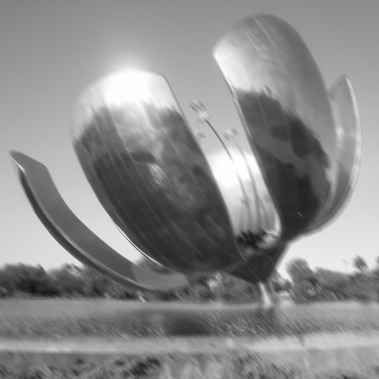

Motion blur con un kernel de 50:


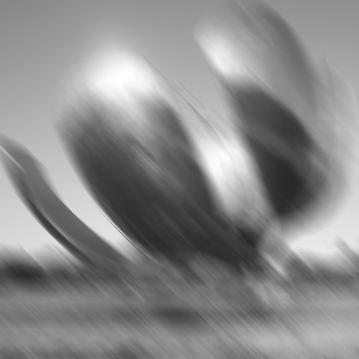

In [13]:
# Abrir la imagen original
img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)

print('Motion blur con un kernel de 10:')
display_np(motion_blur(img, 10), 0.5)

print('Motion blur con un kernel de 50:')
display_np(motion_blur(img, 50), 0.5)

## Ejercicio 5
### Regularizacion y metodos iterativos

## Ejercicio 6
### Eliminación de interferencia

In [ ]:
from PIL import Image
from scipy.fft import fft2, fftshift, ifftshift, ifft2
from matplotlib import pyplot as plt
import numpy as np

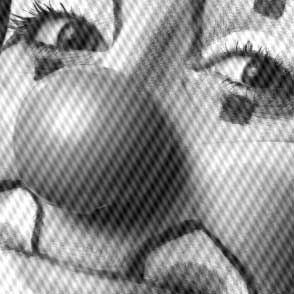

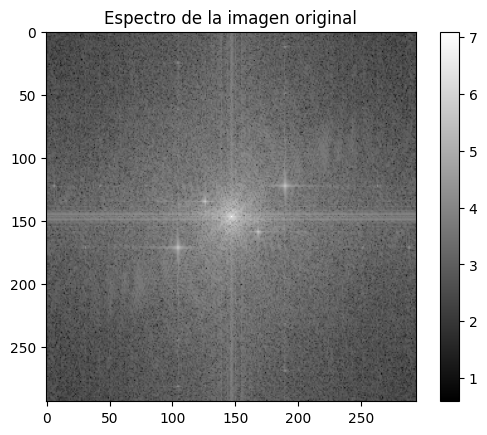

In [ ]:
clown = Image.open("images/clown.jpg")
clown_arr = np.asarray(clown)[:,:,0]
clown_freq = fftshift(fft2(clown_arr))

display(clown)
# Plot spectrum
clown_freq_log = np.log10(np.abs(clown_freq)+1)
plt.imshow(clown_freq_log, cmap="gray", vmin=np.min(clown_freq_log), vmax=np.max(clown_freq_log))
plt.title("Espectro de la imagen original")
plt.colorbar()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_2288\3558466352.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  H[u, v] = ( 1 / (1 + (D0k/Dkplus)**n ) ) * ( 1 / (1 + (D0k/Dkminus)**n ) )


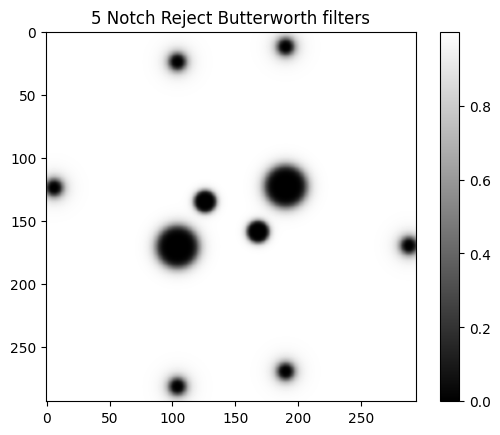

In [ ]:
# Butterworth Notch filter
import numpy as np
from matplotlib import pyplot as plt

def Dk(u:int, v:int, M:int, N:int, uk:int, vk:int) -> float:
    return np.sqrt( (u-M//2-uk)**2  + (v-N//2-vk)**2 )

def notchR2d(D0k, n, M, N, uk, vk):
    H = np.zeros((M,N))
    for u in range(M):
        for v in range(N):
            Dkplus = Dk(u, v, M, N, uk, vk)
            Dkminus = Dk(u, v, M, N, -uk, -vk)
            H[u, v] = ( 1 / (1 + (D0k/Dkplus)**n ) ) * ( 1 / (1 + (D0k/Dkminus)**n ) )
    return H

M = N = 294
Hnotch1 = notchR2d(D0k=17, n=8, M=M, N=N, uk=24, vk=-43)
Hnotch2 = notchR2d(D0k=13, n=8, M=M, N=N, uk=12, vk=21)
Hnotch3 = notchR2d(D0k=7, n=4, M=M, N=N, uk=123, vk=43)
Hnotch4 = notchR2d(D0k=7, n=4, M=M, N=N, uk=23, vk=141)
Hnotch5 = notchR2d(D0k=7, n=4, M=M, N=N, uk=135, vk=-43)
Hnotch = Hnotch1 * Hnotch2 * Hnotch3 * Hnotch4 * Hnotch5

plt.imshow(Hnotch, cmap="gray")
plt.title("5 Notch Reject Butterworth filters")
plt.colorbar()
plt.show()

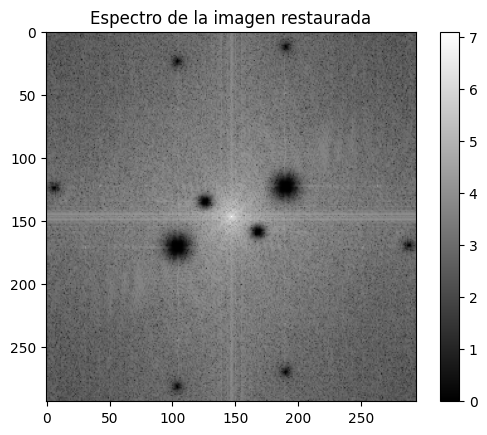

In [ ]:
clown_freq_filtered = np.multiply(clown_freq, Hnotch)

# Plot spectrum of filtered image
clown_freq_filtered_log = np.log10(np.abs(clown_freq_filtered) + 1)
plt.imshow(clown_freq_filtered_log, cmap="gray")
plt.title("Espectro de la imagen restaurada")
plt.colorbar()


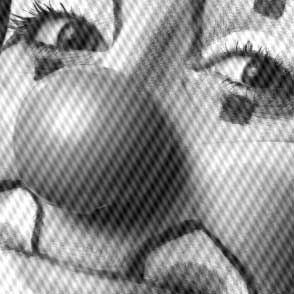

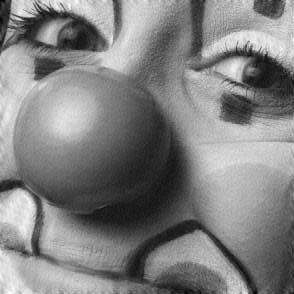

In [ ]:
clown_filtered = np.real(ifft2(ifftshift(clown_freq_filtered)))
plt.imsave("images/clown_filtered.jpg", clown_filtered, format="jpg", cmap="gray")

# Plot original image vs. filtered image
display(clown, Image.open("images/clown_filtered.jpg"))


In [ ]:
# # Butterworth Band Reject filter
# import numpy as np
# from matplotlib import pyplot as plt

# def D(u:int, v:int, M:int, N:int) -> float:
#     return np.sqrt( (u-M//2)**2  + (v-N//2)**2 )

# def butterBR2d(C0, W, n, M, N):
#     H = np.zeros((M,N))
#     for u in range(M):
#         for v in range(N):
#             Duv = D(u, v, M, N)
#             H[u, v] = 1 / (1 + ( (Duv*W) / (Duv**2 - C0**2) )**(2*n) )
#     return H

# M = N = 294
# H2 = butterBR2d(C0=64, W=16, n=2, M=M, N=N)

# plt.imshow(H2, cmap="gray")
# plt.title("Band Reject 2D Butterworth filter of 2th order")
# plt.colorbar()
# plt.show()

# plt.plot(H2[:,N//2])
# plt.title("Band Reject Butterworth filter")
# plt.legend(["n=2"])
# #plt.hlines(y=[gammaL, gammaH], xmin=0, xmax=M, colors="k" ,linestyles="dotted")
# plt.show()
